# Coronavirus outbreak 2020

- Taken world-wide data from

- Source: https://www.worldometers.info/coronavirus/

- Fit growth model of type $t^p$ for infections and deaths

- Predict infection and deaths for the next day based on that model

- starting 21 January 


In [1]:
%%file data.txt
date,infected,deaths
21/jan/2020,446,9
22/jan/2020,579,17
23/jan/2020,844,25
24/jan/2020,1312,41
25/jan/2020,2015,56
26/jan/2020,2801,80
27/jan/2020,4579,106
28/jan/2020,6061,132
29/jan/2020,7816,170
30/jan/2020,9821,213
31/jan/2020,11948,258
01/feb/2020,14551,304
02/feb/2020,17387,362
03/feb/2020,20626,426
04/feb/2020,24553,492
05/feb/2020,28276,565

Overwriting data.txt


In [2]:
%config InlineBackend.figure_formats = ['svg']
import pandas as pd
import scipy.optimize
import numpy as np
import seaborn
import datetime
import matplotlib
import matplotlib.pyplot as plt
seaborn.set()
%matplotlib inline
!mkdir -p figures
figsize = (8, 6)   # need bigger size otherwise xlabels are cut-off in svg files

In [3]:
data = pd.read_csv('data.txt', 
                   parse_dates=[0], 
                   infer_datetime_format=True)
print(f"Last executed: {datetime.date.today().strftime('%d %b %Y')}, "\
      f"last data point from {max(data['date']).strftime('%d %b %Y')}.")

Last executed: 06 Feb 2020, last data point from 05 Feb 2020.


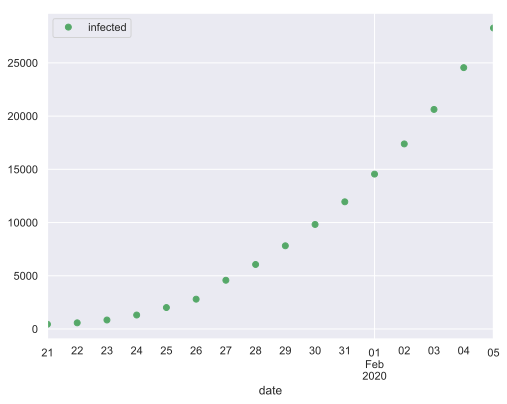

In [4]:
fig, ax = plt.subplots(figsize=figsize)
data.plot('date', 'infected', style='og', ax=ax);
ax.get_figure().savefig('figures/infections.svg')

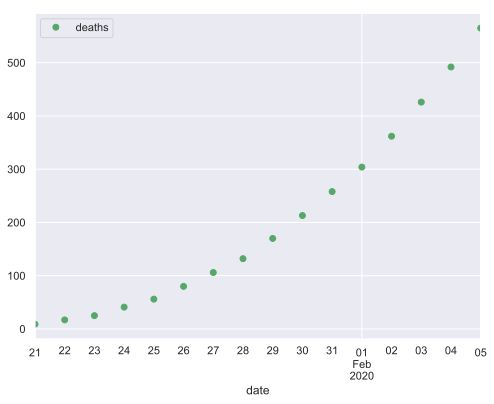

In [5]:
fig, ax = plt.subplots(figsize=figsize)
data.plot('date', 'deaths', style='og', ax=ax)
ax.get_figure().savefig('figures/deaths.svg')

Compute some more useful columns

In [6]:
data['days-td'] = data['date'] - data['date'][0]  # td = TimeDelta
data['days'] = data['days-td'].astype("timedelta64[D]").astype(float)
data['new-infections'] = data['infected'].diff()
data['new-deaths'] = data['deaths'].diff()
# grow factor (see https://www.worldometers.info/coronavirus/coronavirus-cases/#cases-growth-factor)
data['growth-infected'] = data['infected'].pct_change()+1
data['growth-deaths'] = data['deaths'].pct_change()+1
data.to_html('figures/table-1.html')
data

,date,infected,deaths,days-td,days,new-infections,new-deaths,growth-infected,growth-deaths
0,2020-01-21,446,9,0 days,0.0,NaN,NaN,NaN,NaN
1,2020-01-22,579,17,1 days,1.0,133.0,8.0,1.298206,1.888889
2,2020-01-23,844,25,2 days,2.0,265.0,8.0,1.457686,1.470588
3,2020-01-24,1312,41,3 days,3.0,468.0,16.0,1.554502,1.640000
4,2020-01-25,2015,56,4 days,4.0,703.0,15.0,1.535823,1.365854
5,2020-01-26,2801,80,5 days,5.0,786.0,24.0,1.390074,1.428571
6,2020-01-27,4579,106,6 days,6.0,1778.0,26.0,1.634773,1.325000
7,2020-01-28,6061,132,7 days,7.0,1482.0,26.0,1.323651,1.245283
8,2020-01-29,7816,170,8 days,8.0,1755.0,38.0,1.289556,1.287879
9,2020-01-30,9821,213,9 days,9.0,2005.0,43.0,1.256525,1.252941


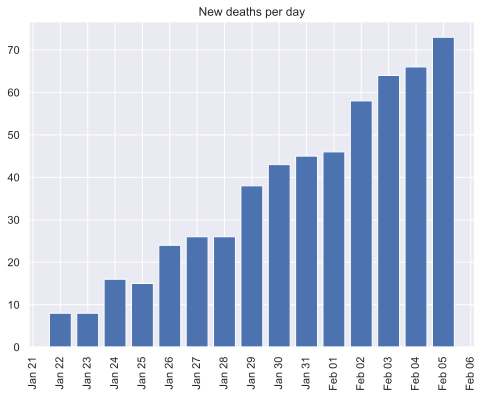

In [7]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(data['date'], data['new-deaths'])
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
ax.tick_params(axis='x', rotation=90)
ax.set_title("New deaths per day")
fig.savefig('figures/new-deaths.svg')

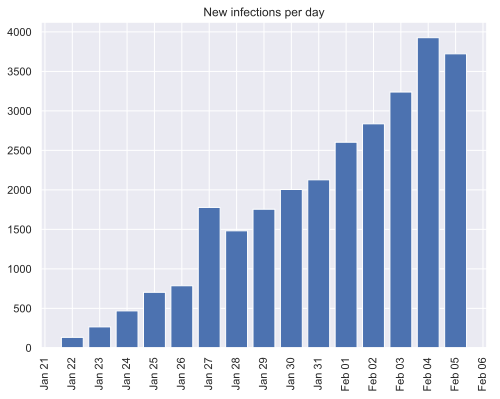

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(data['date'], data['new-infections'])
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
ax.tick_params(axis='x', rotation=90)
ax.set_title("New infections per day")
fig.savefig('figures/new-infections.svg')

The number of new infections on 05 Feb was smaller than that on 04 Feb. This could be the beginning of a slow down in spread. 

In [9]:
def day_to_date(day):
    """Given the day from day0 (21 Jan 2020), return the data as a string.
    Example output: '26 Jan 2020'
    
    Needed to obtain days for predictions into the future, which are not given in our data frame 'data' yet.
    """
    assert isinstance(day, (int, float)), day
    
    # Compute date
    date = pd.datetime(year=2020, month=1, day=21) + pd.Timedelta(day, "D")
    # format nicely
    s = date.strftime("%d %b %Y")
    return s

# Use a trivial growth model to represent the data

We assume a model of type $n(t) = c(t-t_0)^p + a_0$ to describe the growth of the number of infections (or deaths) $n$ as a function of days $t$, and we start counting days from 21 Jan 2020 as day0. The choice of day0 is somewhat random; it was the first data point shown in the data at https://www.worldometers.info/coronavirus/.

In [10]:
def model(t, c, t0, p, a0):
    return c*(t-t0)**p + a0    

The parameters t0 and a0 are relatively uninteresting; they help to fit the data better but are unimportant for the growth behaviour. The key parameters are the exponent $p$ and then the prefactor $c$ in $n(t) = c t^p$.

If $p=2$, we know that the number of infections grows quadratically as a function of time. That means for example that the change from 5 days after day0 to 10 days after day0 (i.e. double it), the number $n$ will have increase by a factor of $2^2 = 4$.

For larger values of $p$, the growth will be faster.

The number $n$ will only go down, if $p$ is smaller than 1.

We use `curve_fit` from `scipy.optimize` to determine parameters.

## Why this model?


- it is a relatively simple model
- it fits the data so far (~10 days from 21 Jan onwards) well
- model allows predictions for infections and deaths *if the spread of the virus carries on as it has so far*
- We thus very much hope that the model stops working, and overestimates infections and deaths



# Global infections

In [11]:
days = data['days']
infections = data['infected']

param_infections, cov = \
    scipy.optimize.curve_fit(model, days, 
                             infections, 
                             p0=(1, 0, 2, 0))  # guess initial values for fit parameters

In [12]:
def pretty_params(param, end="\n"):
    c, t0, p, a0 = param
    s = "p = {:.3f}".format(p) + end
    s += "c = {:.3g}".format(c) + end
    s += "t0= {:.3f}".format(t0) + end
    s += "a0= {:.3f}".format(a0)
    return s

Fit model, and plot.

In [13]:
c, t0, p, a0 = param_infections
fitted_infections = model(days, c, t0, p, a0)
print(pretty_params(param_infections))

p = 2.250
c = 58
t0= -0.559
a0= 375.049


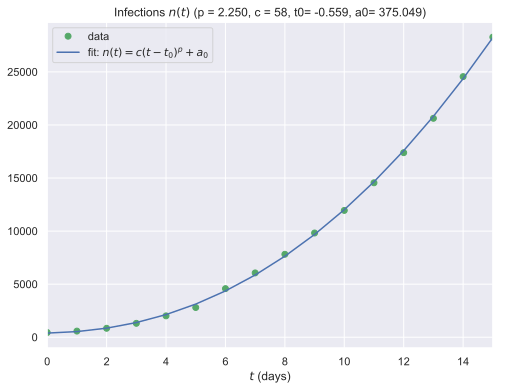

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=figsize)
data.plot('days', 'infected', style='og',ax=ax)
ax.plot(days, fitted_infections, '-b')
ax.legend(["data", "fit: $n(t) = c(t-t_0)^p+a_0$"])
ax.set_title(f"Infections $n(t)$ ({pretty_params(param_infections, end=', ')})")
ax.set_xlabel('$t$ (days)')
fig.savefig('figures/infections-with-model-fit.svg')

### Prediction of infection numbers for tomorrow

Assuming infections keep carry on growing as they have done according to the model:

In [15]:
print(f"Infected people tomorrow: {int(round(model(max(days)+1, c, t0, p, a0)))} ({day_to_date(max(days)+1)})")

Infected people tomorrow: 32417 (06 Feb 2020)


More speculative predictions further into the future:

In [16]:
for future_days in range(1, 11):
    d = int(max(data['days'])) + future_days
    print(f"Infections in {future_days:2} days: ",
          f"{int(round(model(d, c, t0, p, a0))):6}",
          f" ({day_to_date(d)})")

Infections in  1 days:   32417  (06 Feb 2020)
Infections in  2 days:   36936  (07 Feb 2020)
Infections in  3 days:   41787  (08 Feb 2020)
Infections in  4 days:   46977  (09 Feb 2020)
Infections in  5 days:   52509  (10 Feb 2020)
Infections in  6 days:   58388  (11 Feb 2020)
Infections in  7 days:   64617  (12 Feb 2020)
Infections in  8 days:   71202  (13 Feb 2020)
Infections in  9 days:   78145  (14 Feb 2020)
Infections in 10 days:   85451  (15 Feb 2020)


# Deaths

Fit (the same) model, and plot.

In [17]:
days = data['days']
deaths = data['deaths']
param_death, cov = scipy.optimize.curve_fit(model, days, deaths, 
                                          p0=(1, 0, 2, 0))
print(pretty_params(param_death))

p = 2.386
c = 0.602
t0= -2.556
a0= 3.698


In [18]:
fitted_days = days
c, t0, p, a0 = param_death
fitted_deaths = model(fitted_days, c, t0, p, a0)

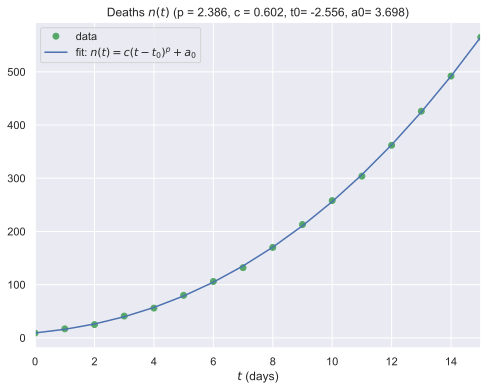

In [19]:
fig, ax = plt.subplots(figsize=figsize)
data.plot('days', 'deaths', style='og',ax=ax)
ax.plot(days, fitted_deaths, '-b')
ax.legend(["data", "fit: $n(t) = c(t-t_0)^p+a_0$"])
ax.set_title(f"Deaths $n(t)$ ({pretty_params(param_death, end=', ')})")
ax.set_xlabel('$t$ (days)')
fig.savefig('figures/deaths-with-model-fit.svg')

## Prediction for tomorrow

Assuming increase of deaths carries on as before

In [20]:
print(f"Deaths tomorrow: {int(round(model(max(days)+1, c, t0, p, a0)))} ({day_to_date(max(days)+1)})")

Deaths tomorrow: 645 (06 Feb 2020)


and more speculative beyond tomorrow

In [21]:
for future_days in range(1, 11):
    d = int(max(data['days'])) + future_days
    print(f"Deaths in {future_days:2} days: ",
          f"{int(round(model(d, c, t0, p, a0))):6}",
          f" ({day_to_date(d)})")

Deaths in  1 days:     645  (06 Feb 2020)
Deaths in  2 days:     730  (07 Feb 2020)
Deaths in  3 days:     822  (08 Feb 2020)
Deaths in  4 days:     920  (09 Feb 2020)
Deaths in  5 days:    1025  (10 Feb 2020)
Deaths in  6 days:    1136  (11 Feb 2020)
Deaths in  7 days:    1254  (12 Feb 2020)
Deaths in  8 days:    1379  (13 Feb 2020)
Deaths in  9 days:    1511  (14 Feb 2020)
Deaths in 10 days:    1650  (15 Feb 2020)


In [22]:
print(f"Last executed: {datetime.date.today().strftime('%d %b %Y')}, "\
      f"last data point from {max(data['date']).strftime('%d %b %Y')}.")

Last executed: 06 Feb 2020, last data point from 05 Feb 2020.


# Discussion

- disclaimer: the whole discussion above is not particularly sophisticated, does not take into account expert knowledge in epidemiology.
- we fit a trivial (monomial-type) model to the numbers, and the fit appears (chi-by-eye) pretty good over the period from 21 Jan to early February. This implies that
- the effect of measures to contain the spread of the disease (lock downs, cancelled flights, ...) is not clearly visible in the data yet


What would be interesting to do?
- evaluate quality of fit quantitatively ($\chi^2$?)
- take simplified growth model ($n = ct^p$?), compute fit for shorter periods of time (5 days?) as a sliding window and see if $p$ changes? (We need it to go down.)



# Other somewhat random data explorations

### With the current growth, when would humans face extinction?

Inspired by [this suggestion from Joseph C Slater](https://twitter.com/JosephCSlater/status/1223739178468413440), we can work out how long it takes until all 7.8 billion people on the planet would be *if the growth rate does not change*. 

In [23]:
# work out solution numerically (in case model is changed later)
def survivors_planet(t, params):
    # Assume 7.8 billion people on planet, https://en.wikipedia.org/wiki/World_population
    return 7.8e9 - model(t, *params)

ndays = scipy.optimize.bisect(survivors_planet, 0, 100000, args=(param_death,))
print(f"Days until extinction: {ndays:.0f}, that's {ndays/365:0.1f} years.") 

Days until extinction: 17283, that's 47.4 years.


## Compare average new infections from model with day-resolved data

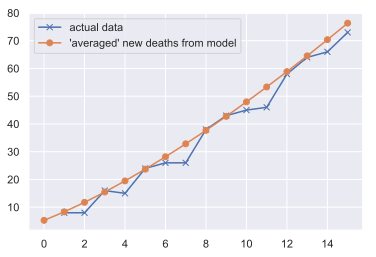

In [24]:
fix, ax = plt.subplots()
# increase per day should be derivative dn/dt = p*c*(t-t0)^(p-1)
derivative = p*c*(data['days']-t0)**(p-1)
ax.plot(data['days'], data['new-deaths'], 'x-', label='actual data')
ax.plot(data['days'], derivative, 'o-', label="'averaged' new deaths from model")
ax.legend()

In [25]:
# The plot above doesn't look quite right. What went wrong?

## How long does it take for the number of infections to double?

- in the news, we had 6.4 days (with the recent [Lancet paper](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext) given as the reference)

- based on $n(t') =  2n(t)$, we find $$t' = \left((2(t-t_0)^p+\frac{a_0}{c}\right)^\frac{1}{p} + t_0$$

- the time for infections or deaths to double is thus given by $t' - t$, and we can implement the above equation:

In [26]:
def time_to_double(t, t0, p, a0, c):
    tprime = (2*(t - t0)**p + a0/c)**(1/p) + t0
    return tprime - t

In [27]:
day = 12 # 
print(f"at day {day:d} ({day_to_date(day)}), the time to double n is {time_to_double(day, t0, p, a0, c):.2}")

at day 12 (02 Feb 2020), the time to double n is 4.9


In [28]:
# sanity check to see if we got the equation right:
for t in range(0, 50, 10):
    double_time = time_to_double(t, t0, p, a0, c)
    should_be_2 = model(t+double_time, c, t0, p, a0) / model(t, c, t0, p, a0)
    print(f"t = {t}, time_to_double = {double_time:.2f}, check: 2.0=={should_be_2:.14}")
    assert abs(should_be_2 - 2) < 1e-14

t = 0, time_to_double = 1.29, check: 2.0==2.0
t = 10, time_to_double = 4.28, check: 2.0==2.0
t = 20, time_to_double = 7.63, check: 2.0==2.0
t = 30, time_to_double = 10.99, check: 2.0==2.0
t = 40, time_to_double = 14.35, check: 2.0==2.0


Create table column with this info

In [29]:
data['double-time-deaths'] = data['deaths'].apply(time_to_double_double)

NameError: name 'time_to_double_double' is not defined